<a href="https://colab.research.google.com/github/mrhamedani/Gen-AI-projects-Pytorch/blob/main/5_blonde_black_hair_CelebFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Download and prepare the Dataset
The eyeglasses dataset we use is from Kaggle. Log into Kaggle and go to the link https://www.kaggle.com/datasets/jessicali9530/celeba-dataset to download the image folder and the two CSV files on the right

Using the Kaggle API JSON file, I saved the data set directly in the Google Colab temporary memory

In [1]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rezahamedani","key":"d5c4f587c7cea3dc259ab608e99e3a8b"}'}

In [2]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [10]:
import pandas as pd
import os, shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import albumentations
from albumentations.pytorch import ToTensorV2
import os
from torch.utils.data import Dataset
import numpy as np
import tqdm
from PIL import Image

In [5]:
df=pd.read_csv("./list_attr_celeba.csv")    #A
os.makedirs("./cyclegan/black", exist_ok=True)
os.makedirs("./cyclegan/blond", exist_ok=True)    #B
folder="./img_align_celeba/img_align_celeba"
for i in range(len(df)):
    dfi=df.iloc[i]
    if dfi['Black_Hair']==1:    #C
        try:
            oldpath=f"{folder}/{dfi['image_id']}"
            newpath=f"./cyclegan/black/{dfi['image_id']}"
            shutil.move(oldpath, newpath)
        except:
            pass
    elif dfi['Blond_Hair']==1:    #D
        try:
            oldpath=f"{folder}/{dfi['image_id']}"
            newpath=f"./cyclegan/blond/{dfi['image_id']}"
            shutil.move(oldpath, newpath)
        except:
            pass

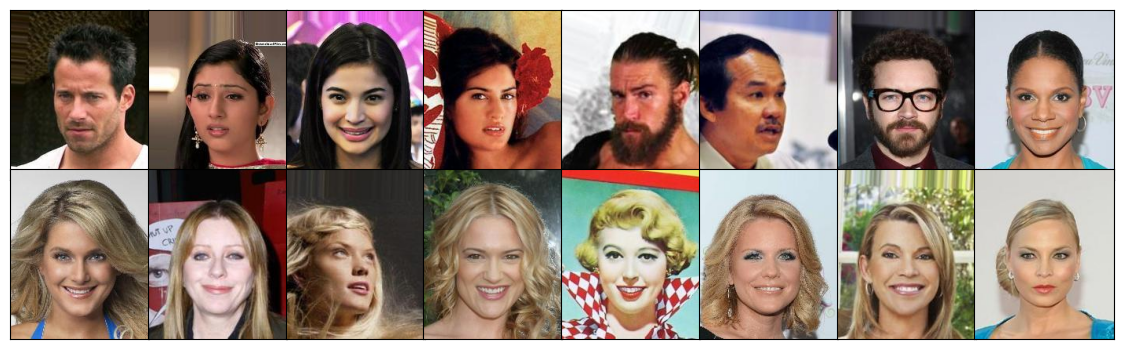

In [21]:
trainA = "./cyclegan/black/"
trainB = "./cyclegan/blond/"

random.seed(5)
imgs = os.listdir(trainA)
samples = random.sample(imgs, 8)
imgs1 = os.listdir(trainB)
samples1 = random.sample(imgs1, 8)

fs = [trainA, trainB]
ps = [samples, samples1]

fig = plt.figure(dpi=100, figsize=(1.78 * 8, 2.18 * 2))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    folder = i // 8
    p = i % 8
    img = Image.open(fr"{fs[folder]}{ps[folder][p]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(wspace=-0.01, hspace=-0.1)
plt.show()


In [22]:
class LoadData(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        super().__init__()
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform
        self.A_images = []
        self.B_images = []

        for r in root_A:
            files=os.listdir(r)
            self.A_images += [r+i for i in files]

        for r in root_B:
            files=os.listdir(r)
            self.B_images += [r+i for i in files]

        self.len_data = max(len(self.A_images), len(self.B_images))
        self.A_len = len(self.A_images)
        self.B_len = len(self.B_images)

    def __len__(self):
        return self.len_data

    def __getitem__(self, index):
        A_img = self.A_images[index % self.A_len]
        B_img = self.B_images[index % self.B_len]
        A_img = np.array(Image.open(A_img).convert("RGB"))
        B_img = np.array(Image.open(B_img).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=B_img, image0=A_img)
            B_img = augmentations["image"]
            A_img = augmentations["image0"]
        return A_img, B_img

In [23]:
transforms = albumentations.Compose([
                                    albumentations.Resize(width=256, height=256), albumentations.HorizontalFlip(p=0.5),
                                    albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
                                    ToTensorV2()], additional_targets={"image0": "image"})

dataset = LoadData(root_A=["./cyclegan/black/"], root_B=["./cyclegan/blond/"], transform=transforms)

loader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)